# CSE 152: Intro to Computer Vision - Spring 2019 Assignment 1
## Instructor: David Kriegman
### Assignment published on Friday, April 12, 2019
### Due on Wednesday, April 24, 2019 at 11:59pm

## Instructions
* This assignment must be completed individually. Review the academic integrity and collaboration policies on the course website.
* All solutions should be written in this notebook.
* If you want to modify the skeleton code, you may do so. It has been merely been provided as a framework for your solution.
* You may use Python packages for basic linear algebra (e.g. NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem. If you are unsure about using a specific package or function, ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as an `.ipynb` file. Submit both files (`.pdf` and `.ipynb`) on Gradescope. **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy:** a penalty of 10% per day after the due date.

---

In [1]:
# Setup
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

## Geometric Image Formation

In this problem, we'll practice applying perspective projection and rigid transformations. Our goal will be to photograph the following four points, which are currently in the frame $A$ coordinate system. (This is not necessarily the same as the camera frame.)

\begin{align*}
^AP_1 = \begin{bmatrix}-2 \\ -1 \\ 3\end{bmatrix},~
^AP_2 = \begin{bmatrix}2 \\ -1 \\ 3\end{bmatrix},~
^AP_3 = \begin{bmatrix}2 \\ 1 \\ 3\end{bmatrix},~
^AP_4 = \begin{bmatrix}-2 \\ 1 \\ 3\end{bmatrix}
\end{align*}

In order to accomplish our simulated photography goals, we will need to make use of intrinsic and extrinsic matrices for image formation. The first step in any given projection process will be rigid transformation(s) which put the coordinates of the point into the frame of the camera. A rigid transformation can be written

$$^BP = \text{ } ^B_AR\text{ }^AP + \text{ } ^BO_A$$

where $^BP$ is the point in the target ($B$) coordinate frame. $^AP$ is the point in the source ($A$) coordinate frame. $^B_AR$ is the rotation matrix from $A$ to $B$, and $^BO_A$ is the origin of the coordinate system $A$ expressed in $B$ coordinates. The rotation and translation from system $A$ to system $B$ can be combined into a single 4 $\times$ 4 extrinsic matrix, $P_e$, s.t. $^BP = P_e \cdot \text{ }^AP$. 

Then the point(s) in camera coordinates can be photographed using the intrinsic matrix, $P_i$, which is a 3 $\times$ 4 matrix transforming homogeneous 3D points to homogeneous 2D image points. Mathematically, the image of a point $^AP$ can be calculated as $P_i \cdot P_e \cdot \text{ }^AP$. For more details, see Lecture 2.

(Alternatively, the extrinsic matrix can be $3 \times 4$ and the intrinsic matrix can be $3 \times 3$, but as our current formulation keeps all intermediate results in homogeneous coordinates, we will go with that one.)

We will consider five different settings of focal length, viewing angle, and camera position (see below). For each of these, you should calculate the extrinsic and intrinsic matrices for pinhole perspective projection, and then use said matrices to compute and plot the image of the four vertices.

1. **[No rigid body transformation]** Focal length = 1. The optical axis of the camera is aligned with the z-axis.
2. **[Translation]** Focal length = 1. The optical axis of the camera is aligned with the z-axis. $^BO_A = [\text{0 0 2}]^T$.
3. **[Translation and rotation]** Focal length = 1. $^B_AR$ encodes a 60 degrees around the z-axis and then 30 degrees around the y-axis. $^BO_A = [\text{0 0 2}]^T$.
4. **[Translation and rotation, long distance]** Focal length = 7. $^B_AR$ encodes a 60 degrees around the z-axis and then 30 degrees around the y-axis. $^BO_A = [\text{0 0 11}]^T$.
5. **[Two rigid transformations]** Focal length = 7. $^B_AR$ encodes a 60 degrees around the z-axis and then 30 degrees around the y-axis. $^BO_A = [\text{0 0 11}]^T$. $^C_BR = \begin{bmatrix}1 & 0 & 0 \\ 0 & 0.834 & -0.546 \\ 0 & 0.546 & 0.834\end{bmatrix}^{-1}$. $^CO_B = [\text{1 2 1}]^T$. For this case, the camera frame is frame $C$. Also, note the inverse on the rotation matrix. Do not use a predefined matrix inverse function to compute this inverse (except for verification if you wish); instead use the fact that it is an orthogonal matrix and apply one of the properties of orthogonal matrices to more efficiently compute the inverse. (If you are not sure what we are referring to, consult page 20 of the Lecture 2 slides and check the properties of rotation matrices.)

Note that we will not use a full intrinsic camera matrix (one that maps centimeters to pixels and defines the  coordinates of the center of projection). The only intrinsic parameter we will use is the focal length $f$. (The other parameters should therefore be set to 0 in the intrinsic matrix.) Use the perspective equations $\frac{fx}{z}$, $\frac{fy}{z}$ i.e. without the negative sign.

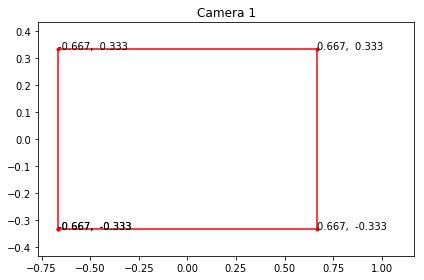

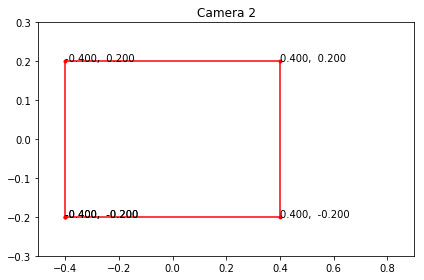

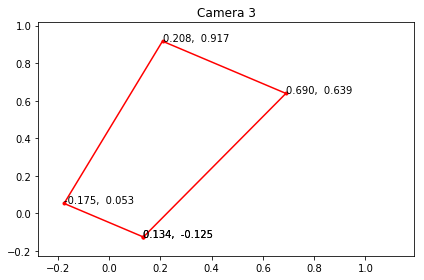

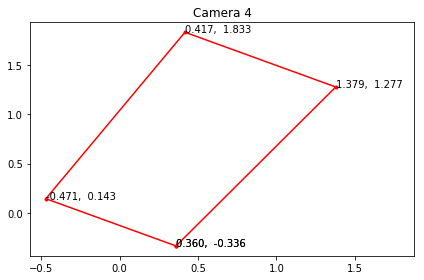

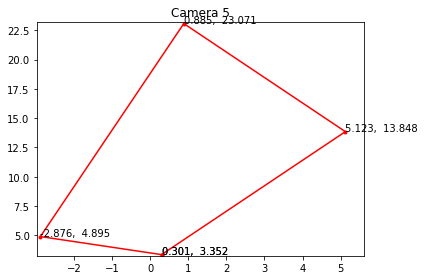

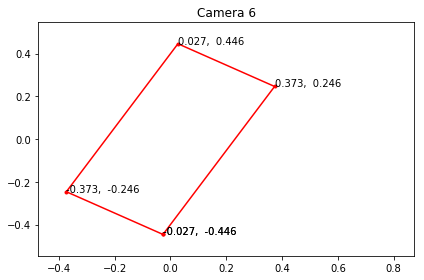

In [2]:
# convert points from Euclidean to homogeneous
def to_homog(points):
    return np.concatenate((points,np.ones([1,points.shape[1]])))

# convert points from homogeneous to Euclidean
def from_homog(points_homog):
    return points_homog[:-1]/points_homog[-1]

# project 3D Euclidean points to 2D Euclidean
def project_points(P_int, P_ext, pts):
    homo_3d = to_homog(pts)
    M =np.dot(P_int,P_ext)
    homo_2d = np.dot(M,homo_3d)
    euc_2d = from_homog(homo_2d)
    return euc_2d



# In the five camera functions below, change the matrices as per each of the cases as described above.
# Make sure that we can see the formula (if one exists) being used to fill in the matrices.
# If there is anything you feel the need to explain, feel free to document it with comments.

def rotateMat(axis,degree):
    assert axis in ['z','y','x']
    assert 0<=degree<=360
    radian = degree * np.pi / 180
    if axis=='x':
        rM = np.array([[1,0,0],[0,np.cos(radian),-np.sin(radian)],[0,np.sin(radian),np.cos(radian)]])
    elif axis=='y':
        rM = np.array([[np.cos(radian),0,np.sin(radian)],[0,1,0],[-np.sin(radian),0,np.cos(radian)]])
    else:
        rM = np.array([[np.cos(radian),-np.sin(radian),0],[np.sin(radian),np.cos(radian),0],[0,0,1]])
    return rM
        
def camera1():
    f=1
    P_int = np.eye(3,4)
    P_int[[0,1],[0,1]] = f
    P_ext = np.eye(4,4)
    return P_int, P_ext

def camera2():
    f=1
    P_int = np.eye(3,4)
    P_int[[0,1],[0,1]] = f
    P_ext = np.eye(4,4)
    P_ext[:3,-1] = np.array([0,0,2]).T
    return P_int, P_ext

def camera3():
    f=1
    P_int = np.eye(3,4)
    P_int[[0,1],[0,1]] = f
    P_ext = np.eye(4,4)
    P_ext[:3,-1] = np.array([0,0,2]).T
    rzM = rotateMat('z',60)
    ryM = rotateMat('y',30)
    rM = np.dot(rzM,ryM)
    P_ext[:3,:3] = rM
    return P_int, P_ext

def camera4():    
    # write your code here

    f=7
    P_int = np.eye(3,4)
    P_int[[0,1],[0,1]] = f
    P_ext = np.eye(4,4)
    P_ext[:3,-1] = np.array([0,0,11]).T
    rzM = rotateMat('z',60)
    ryM = rotateMat('y',30)
    rM = np.dot(rzM,ryM)
    P_ext[:3,:3] = rM
    return P_int, P_ext

def camera5():    
    # write your code here
    f=7
    P_int = np.eye(3,4)
    P_int[[0,1],[0,1]] = f
    P_ext_AB = np.eye(4,4)
    P_ext_AB[:3,-1] = np.array([0,0,11]).T
    rzM = rotateMat('z',60)
    ryM = rotateMat('y',30)
    rM_AB = np.dot(rzM,ryM)
    P_ext_AB[:3,:3] = rM_AB
    P_ext_BC = np.eye(4,4)
    rM_BC = np.array([[1,0,0],[0,0.834,-0.546],[0,0.546,0.834]]).T
    P_ext_BC[:3,:3] = rM_BC
    P_ext_AB[:3,-1] = np.array([1,2,1]).T
    P_ext = np.dot(P_ext_AB,P_ext_BC)
    return P_int, P_ext

def camera6():
    f=1
    P_int = np.eye(3,4)
    P_int[[0,1],[0,1]] = f
    P_ext = np.eye(4,4)
    P_ext[:3,-1] = np.array([0,0,2]).T
    rM = rotateMat('z',60)
    P_ext[:3,:3] = rM
    return P_int, P_ext

# Use the following code to display your outputs
# You are free to change the axis parameters to better 
# display your quadrilateral but do not remove any annotations

def plot_points(points, title='', style='.-r', axis=[]):
    inds = list(range(points.shape[1])) + [0]
    plt.plot(points[0,inds], points[1,inds], style)
    
    for i in range(len(points[0,inds])):
        plt.annotate(
            str("{0:.3f}".format(points[0, inds][i])) + ",  " + str("{0:.3f}".format(points[1, inds][i])),
            (points[0, inds][i], points[1, inds][i]))
    
    if title:
        plt.title(title)
    if axis:
        plt.axis(axis)
        
    plt.tight_layout()

point1 = np.array([[-2, -1, 3]]).T
point2 = np.array([[2, -1, 3]]).T
point3 = np.array([[2, 1, 3]]).T
point4 = np.array([[-2, 1, 3]]).T
points = np.hstack((point1, point2, point3, point4))

for i, camera in enumerate([camera1, camera2, camera3, camera4, camera5,camera6]):
    P_int, P_ext = camera()
    plt.subplot(1, 1, 1)
    proj_points = project_points(P_int, P_ext, points)
    x_neg = np.min(proj_points[0])-0.1
    x_pos = np.max(proj_points[0])+0.5
    y_neg = np.min(proj_points[1])-0.1
    y_pos = np.max(proj_points[1])+0.1
    plot_points(proj_points, title='Camera %d'%(i+1), axis=[x_neg,x_pos,y_neg,y_pos])
    plt.show()

## Filtering

In this problem, you will implement the convolution filtering operation in NumPy.

As shown in the lecture, a convolution can be considered as a sliding window that computes a sum of the pixel values weighted by the flipped kernel. Your version will i) zero-pad an image, ii) flip the kernel horizontally and vertically, and iii) compute a weighted sum of the neighborhood at each pixel.

First you will want to implement the **zero_pad** function.

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


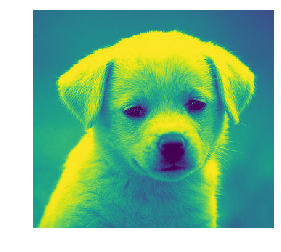

(380, 372)
(300, 332)


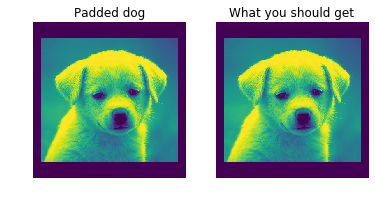

In [3]:
def zero_pad(image, pad_top, pad_down, pad_left, pad_right):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_top = 1, pad_down = 1, pad_left = 2, pad_right = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W)
        pad_width: width of the zero padding (left and right padding)
        pad_height: height of the zero padding (bottom and top padding)

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width)
    """

    H, W = image.shape
    out = np.zeros((H + pad_top + pad_down, W + pad_left + pad_right))
    if pad_down==0 or pad_right==0:
        if pad_down==0 and pad_right==0:
            out = image
        elif pad_right!=0:
            out[pad_top:,pad_left:-pad_right] = image
        else:
            out[pad_top:-pad_down,pad_left:] = image 
    else:
        out[pad_top:-pad_down,pad_left:-pad_right] = image
    
    return out

# Open image as grayscale
img = io.imread('dog.jpg', as_grey=True)
#img = imread('dog.jpg', mode='F')

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()

pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_height, pad_width, pad_width)
print(padded_img.shape)
print(img.shape)

# Plot your padded dog
plt.subplot(1,2,1)
plt.imshow(padded_img)
plt.title('Padded dog')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('padded_dog.jpg', as_grey=True)
#solution_img = imread('padded_dog.jpg', mode='F')
plt.subplot(1,2,2)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

In [4]:
print(zero_pad(np.array([[1]]), 1, 1, 2, 2))

[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


Now implement the function **`conv`**, **using at most 2 loops**. This function should take an image $f$ and a kernel $h$ as inputs and output the convolved image $(f*h)$ that has the same shape as the input image (use zero padding to accomplish this). Depending on the computer, your implementation should take around a second or less to run.

took 0.987843 seconds.


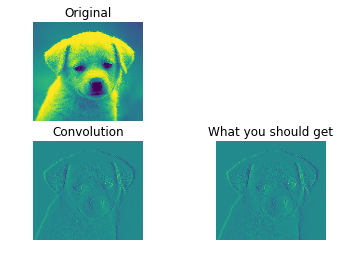

In [5]:
'''
even 
# # # #
# * * *
# * * *
# * * *

odd
# # # # # 
# * * * #
# * * * #
# * * * #
# # # # #
'''


def conv(image, kernel):
    import math
    """ An efficient implementation of a convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute a weighted sum of the neighborhood at each
    pixel.

    Hints:
        - Use the zero_pad function you implemented above
        - You should need at most two nested for-loops
        - You may find np.flip() and np.sum() useful
        - You need to handle both odd and even kernel size

    Args:
        image: numpy array of shape (Hi, Wi)
        kernel: numpy array of shape (Hk, Wk)

    Returns:
        out: numpy array of shape (Hi, Wi)
    """
    if 1 in kernel.shape: 
        if kernel.shape[0]==1:
            flip_kernel = np.flip(kernel,0)
        else:
            flip_kernel = np.flip(kernel,1)
    else:
        flip_kernel = np.flip(kernel,0)
        flip_kernel = np.flip(flip_kernel,1)
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))
    padd_H = math.floor(Hk/2)
    padd_W = math.floor(Wk/2)
    padd = list()
    if Hk%2==1:
        padd.append(padd_H)
        padd.append(padd_H)
    else:
        padd.append(padd_H)
        padd.append(padd_H-1)
    if Wk%2==1:
        padd.append(padd_W)
        padd.append(padd_W)
    else:
        padd.append(padd_W)
        padd.append(padd_W-1)
        
    pad_img = zero_pad(image,padd[0],padd[1],padd[2],padd[3])
    for i in range(Hi):
        for j in range(Wi):
            out[i,j] = np.sum(pad_img[i:i+Hk,j:j+Wk]*flip_kernel)
    assert out.shape==image.shape
    return out

# Simple convolution kernel.
# Feel free to change the kernel and to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

t1 = time()
out = conv(img, kernel)
t2 = time()
print("took %f seconds." % (t2 - t1))

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot your convolved image
plt.subplot(2,2,3)
plt.imshow(out)
plt.title('Convolution')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('convolved_dog.jpg', as_grey=True)
plt.subplot(2,2,4)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

In [6]:
a = np.ones([4,4])
b = np.ones([1,3])
print(conv(a,b))

[[2. 3. 3. 2.]
 [2. 3. 3. 2.]
 [2. 3. 3. 2.]
 [2. 3. 3. 2.]]


Now let's filter some images! Here, you will apply the convolution function that you just implemented in order to bring about some interesting image effects. More specifically, we will use convolution to blur and sharpen our images.

First we will apply convolution for image blurring. To accomplish this, convolve the dog image with a 9x9 Gaussian filter for $\sigma = 5$. You can use the included function to obtain the Gaussian kernel.

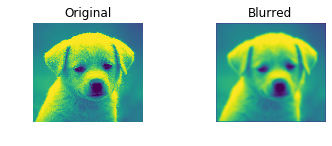

In [7]:
def gaussian2d(filter_size=5, sig=1.0):
    """
    Creates 2D Gaussian kernel with side length `filter_size` and a sigma of `sig`.
    Source: https://stackoverflow.com/a/43346070
    """
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

def blur_image(img):
    """Blur the image by convolving with a Gaussian filter."""
    blur_img = conv(img,gaussian2d(9,5))
    return blur_img

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot blurred image
plt.subplot(2,2,2)
plt.imshow(blur_image(img))
plt.title('Blurred')
plt.axis('off')

plt.show()

Next, we will use convolution to sharpen the images. Convolve the image with the following filter to produce a sharpened result. For convenience, we have defined the filter for you:

In [8]:
sharpening_kernel = np.array([
    [1, 4,     6,  4, 1],
    [4, 16,   24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16,   24, 16, 4],
    [1,  4,    6,  4, 1],
]) * -1.0 / 256.0

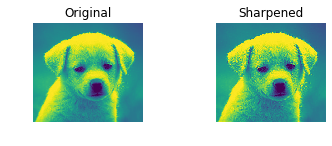

In [9]:
def sharpen_image(img):
    """Sharpen the image by convolving with a sharpening filter."""
    sharp_img = conv(img,sharpening_kernel)
    return sharp_img

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img, vmin=0.0, vmax=1.0)
plt.title('Original')
plt.axis('off')

# Plot sharpened image
plt.subplot(2,2,2)
plt.imshow(sharpen_image(img), vmin=0.0, vmax=1.0)
plt.title('Sharpened')
plt.axis('off')

plt.show()

## Template Matching

Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

Luckily, you have learned in CSE 152 (or are learning right now) that convolution can be used for template matching: a template g is multiplied with regions of a larger image f to measure how similar each region is to the template. Note that you will want to flip the filter before giving it to your convolution function, so that it is overall not flipped when making comparisons. You will also want to subtract off the mean value of the image or template (whichever you choose, subtract the same value from both the image and template) so that our solution is not biased toward higher-intensity (white) regions.

The template of a product (template.jpg) and the image of the shelf (shelf.jpg) is provided. We will use convolution to find the product in the shelf.

<img src="template.jpg" alt="template" width="25px"/>
<img src="shelf.jpg" alt="shelf" width="600px"/>

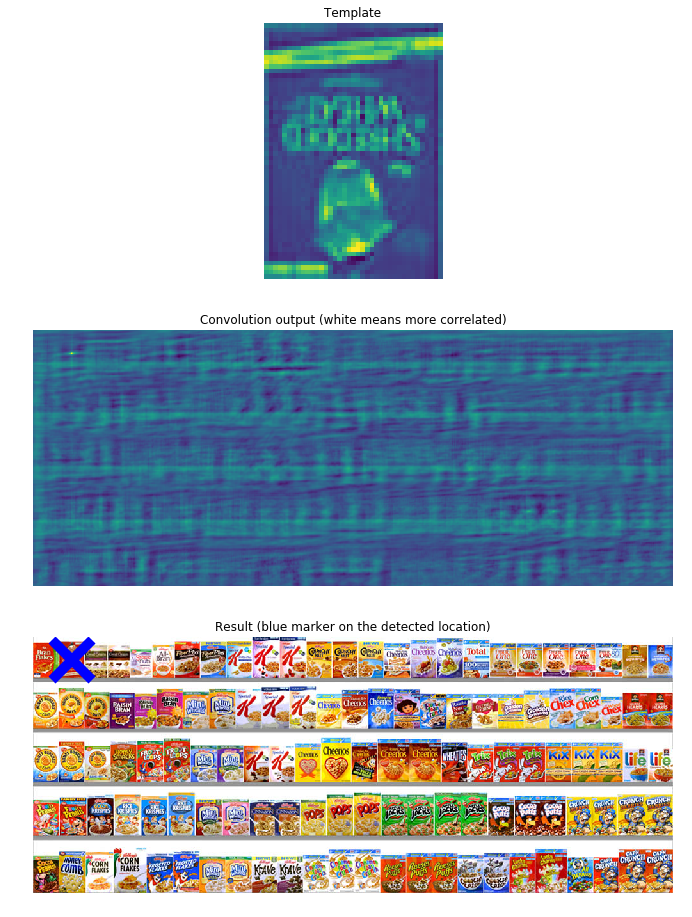

In [10]:
# Load template and image in grayscale
img = io.imread('shelf.jpg')
img_grey = io.imread('shelf.jpg', as_grey=True)
temp = io.imread('template.jpg')
temp_grey = io.imread('template.jpg', as_grey=True)

img_grey = img_grey - np.mean(temp_grey)
temp_grey = temp_grey - np.mean(temp_grey)
temp_grey = np.flip(temp_grey,0) 
temp_grey = np.flip(temp_grey,1)

# Perform a convolution between the image and the template
out = conv(img_grey,temp_grey)

# Find the location with maximum similarity
# Converts a flat index or array of flat indices into a tuple of coordinate arrays.
y, x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(20,16))
plt.subplot(3, 1, 1)
plt.imshow(temp_grey)
plt.title('Template')
plt.axis('off')

# Display convolution output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Convolution output (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()

## Corner Detection

Next, you will implement a corner detector to detect photo-identifiable features in the image.

This should be done according to http://cseweb.ucsd.edu/classes/sp19/cse152-a/lec4.pdf. You should fill in the function <code>corner_detect</code> with inputs <code>image, nCorners, smoothSTD, windowSize</code>, where smoothSTD is the standard deviation of the smoothing kernel and windowSize is the window size for Gaussian smoothing, corner detection, and non-maximum suppression. In the lecture the corner detector was implemented using a hard threshold. Do not do that; instead return the nCorners strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. You can use your previous convolution function alongside the previous Gaussian kernel function in order to smooth the image.

For each image, detect 100 corners with a Gaussian standard deviation of 2.0 and a window size of 11. Display your outputs in a matplotlib figure.

In [11]:
def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).

    """
    """
    Your code here:
    """
    corners = np.zeros((nCorners, 2))
    smooth = conv(image,gaussian2d(windowSize,smoothSTD))
    [sx, sy] = np.gradient(smooth)
    cnt = 0
    temp = int(windowSize/2)
    Ix = sx**2
    Iy = sy**2
    Ixy = sx*sy
# shi-tomasi corner detector
    E = np.zeros((image.shape[1],image.shape[0]))
    for col in range(temp,image.shape[1]-temp+1):        
        for row  in range (temp,image.shape[0]-temp+1):
            #Construct the C matrix to get eigenvalues
            C = np.zeros([2,2])
            C[0][0] = np.sum(Ix[row-temp:row+temp+1,col-temp:col+temp+1])
            C[1][0] = np.sum(Ixy[row-temp:row+temp+1,col-temp:col+temp+1])
            C[0][1] = C[1][0]
            C[1][1] = np.sum(Iy[row-temp:row+temp+1,col-temp:col+temp+1])
            eig_v = np.linalg.eigvals(C)
            E[row][col] = min(eig_v)
#NMS: the maximal value which is larger than its neighbors and the window size should be smaller 
#or equal to the original window size
    value = []
    poss = []
    if windowSize > 3:
        small_win = windowSize-2
    else:
        small_win = 3
    temp2 = int(small_win/2)
    for c in range(temp+temp2,E.shape[1]-temp-temp2+1):
        for r in range(temp+temp2,E.shape[0]-temp-temp2+1):
            #sliding window for NMS
            win = np.zeros((small_win,small_win))
            win = E[r-temp2:r+temp2+1,c-temp2:c+temp2+1]
            if (E[r][c] == win.max()) :
                poss.append([c,r])
                value.append(E[r][c])
    
    poss = np.array(poss)
    value = np.array(value)
    ind = np.argpartition(value, -nCorners)[-nCorners:]
    corners = poss[ind]
    
    return corners

0.0200617567851058
217164.55506565404
0.0
188100.54120736592


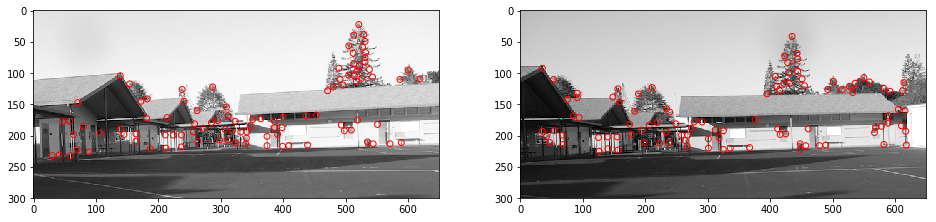

In [12]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def corner_detect(image, nCorners, smoothSTD, windowSize):
    import math
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for Gaussian smoothing kernel, corner detector, and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).

    """
    h,w = image.shape
    gaussWindowSize = 10
    filt_img = conv(image,gaussian2d(filter_size=gaussWindowSize,sig=smoothSTD))
    Ix = conv(filt_img,np.array([[1,0,-1]]))
    Iy = conv(filt_img,np.array([[1,0,-1]]).T)
    #[Ix,Iy] = np.gradient(filt_img)
    
    lmd = np.zeros([h,w])
    sumWindowSize = 8
    Ix2 = conv(np.square(Ix),np.ones([sumWindowSize,sumWindowSize])) 
    Iy2 = conv(np.square(Iy),np.ones([sumWindowSize,sumWindowSize]))
    Ixy = conv(Ix*Iy,np.ones([sumWindowSize,sumWindowSize]))
    for i in range(h):
        for j in range(w):
            #lmd[i,j] = np.ndarray.min(np.roots([1,-(Ix2[i,j]+Iy2[i,j]),Ix2[i,j]*Iy2[i,j]-Ixy[i,j]**2]))
            lmd[i,j] = min(np.linalg.eigvals(np.array([[Ix2[i,j],Ixy[i,j]],[Ixy[i,j],Iy2[i,j]]])))
    print(np.amin(lmd))
    print(np.amax(lmd))
            
    corners = np.zeros((nCorners, 2))
    max_lmds = dict()
    #padd = math.floor(windowSize/2)
    #lmd = zero_pad(lmd,padd,padd,padd,padd)
    windowSize = 9
    
    # rid off high lambdas close to edge, since it results from zero padding
    lmd[:,0:30] = 0
    lmd[:,620:650] = 0
    
    for i in range(0,h-windowSize):
        for j in range(0,w-windowSize):
            window = np.zeros((windowSize,windowSize))
            iPos,jPos = np.unravel_index(lmd[i:i+windowSize,j:j+windowSize].argmax(),(windowSize,windowSize))
            # iPos and jPos also at the middle of window to make sure your dont get too close points
            if (j+jPos,i+iPos) not in max_lmds and iPos==math.floor(windowSize/2) and jPos==math.floor(windowSize/2):    
                max_lmds[(j+jPos,i+iPos)] = lmd[i+iPos,j+jPos]
            window[iPos,jPos] = lmd[i+iPos,j+jPos]
            lmd[i:i+windowSize,j:j+windowSize] = window


    for count,lmd_ij in enumerate(sorted(max_lmds.items(),key = lambda k:-k[1])):
        corners[count,:] = lmd_ij[0]
        count = count + 1
        if count == nCorners:
            break
    
    return corners

# detect corners on the two provided images
# adjust your corner detection parameters here
nCorners = 100
smoothSTD = 2
windowSize = 11

# read images and detect corners on images
imgs = []
corners = []
for i in range(2):
    img = io.imread('almond' + str(i) + '.jpg')
    imgs.append(rgb2gray(img))
    corners.append(corner_detect(imgs[-1], nCorners, smoothSTD, windowSize))

def show_corners_result(imgs, corners):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.show()

show_corners_result(imgs, corners)

## Feature Matching using SIFT

We have two overlapping images of a scene, and we would like to detect and match features (corners) across them. In order to do so, we will compute feature descriptors for the patches around the points and perform matching using a "sum of squared differences" metric.

First, you will want to implement a function which computes said metric. Given two vectors, `ssd` should return the sum of squared differences of their values:

$$ssd(v, w) = \sum_i (v_i - w_i)^2$$

In [13]:
def ssd(v1, v2):
    """Compute SSD (sum of squared differences) for two NumPy arrays.
    This function will come in handy for descriptor matching later.
    """
    
    return np.sum(np.square(v1-v2))

Now use your `ssd` function to perform feature matching. In the `SIFT_matching` function, you should extract SIFT descriptors for the patches around the corners you've detected, then give each potential pair of matching descriptors to the `ssd` function to compute the distance between them. Also make use of Lowe's nearest neighbor thresholding idea, which says that the similarity of the closest match should be much higher than the similarity of the next-closest match. You can check this using the ratio of the SSD distance with the closest match and the next-closest match. By Lowe's empirical findings, you should only accept the best match if the ratio between its distance and the second-best distance is ~0.75 or less. For better-looking results, please use a ratio of 0.3 for the purposes of this homework.

<img src="lowe.png" alt="lowe" width="500px"/>

We will use OpenCV's implementation of SIFT. To install OpenCV with pip, you can run
```
pip install opencv-python==3.4.2.16
pip install opencv-contrib-python==3.4.2.16
```
Please use this version of OpenCV, as earlier or later versions may not have everything you need. After creating a SIFT object with `cv.xfeatures2d.SIFT_create`, you should use the `sift.compute` function, not `sift.detectAndCompute` function, since we still want to use the corners that we've detected.

To summarize: in this question, you should extract SIFT descriptors for each corner. Then you should match SIFT descriptors according to an SSD metric. Check the ratio of the best match's distance to the second best match's distance and only accept the best match if it is significantly better than the next best match (i.e. it involves a significantly lower distance).

**If necessary, tune the parameters so that you end up with about 20 feature matches (starting with your 100 corners from the previous question).**

100 keypoints1
[(332.0, 194.0), (364.0, 173.0), (351.0, 174.0), (258.0, 181.0), (535.0, 210.0), (212.0, 220.0), (285.0, 179.0), (181.0, 172.0), (241.0, 145.0), (164.0, 197.0), (139.0, 104.0), (531.0, 82.0), (399.0, 217.0), (398.0, 187.0), (531.0, 49.0), (493.0, 183.0), (164.0, 209.0), (347.0, 184.0), (587.0, 110.0), (237.0, 218.0), (386.0, 187.0), (323.0, 177.0), (182.0, 141.0), (505.0, 103.0), (172.0, 145.0), (505.0, 56.0), (319.0, 191.0), (342.0, 194.0), (145.0, 198.0), (237.0, 199.0), (600.0, 95.0), (340.0, 213.0), (498.0, 192.0), (238.0, 126.0), (391.0, 198.0), (509.0, 191.0), (453.0, 167.0), (307.0, 190.0), (531.0, 75.0), (544.0, 213.0), (59.0, 232.0), (224.0, 199.0), (374.0, 201.0), (309.0, 154.0), (341.0, 204.0), (538.0, 94.0), (514.0, 104.0), (400.0, 170.0), (154.0, 117.0), (374.0, 216.0), (489.0, 92.0), (527.0, 58.0), (89.0, 226.0), (513.0, 39.0), (518.0, 97.0), (517.0, 113.0), (513.0, 85.0), (295.0, 176.0), (256.0, 194.0), (619.0, 109.0), (262.0, 160.0), (287.0, 122.0), (491.

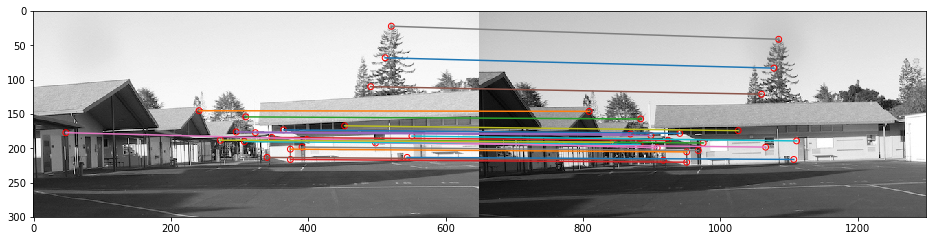

In [14]:
import cv2

def SIFT_matching(img1, img2, corners1, corners2, SSDth, nn_threshold):
    """Compute matchings between two windows based on SIFT descriptors.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        SSDth: SSD distance threshold
        NNth: nearest neighbor threshold

    Returns:
        matching result – a list of (c1, c2) tuples, where
        c1 is the 1x2 corner location in image 1, and
        c2 is the 1x2 corner location in image 2. 

    """
    
    """
    Your code here:
    (feel free to change the below code, it is only provided for reference)
    (you do not need to print out keypoints or descriptors in this function)
    """
    if img1.dtype == np.float64:
        img1 = (img1 * 255.0).astype(np.uint8)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints1 = [cv2.KeyPoint(c[0], c[1], 1) for c in corners1]
    keypoints1, descriptors1 = sift.compute(img1, keypoints1)
    corners1 = [(kp.pt[0], kp.pt[1]) for kp in keypoints1]
    print('%d keypoints1' % len(keypoints1))
    print(corners1)
    print('%d descriptors1' % len(descriptors1))
    print(descriptors1)
    
    if img2.dtype == np.float64:
        img2 = (img2 * 255.0).astype(np.uint8)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints2 = [cv2.KeyPoint(c[0], c[1], 1) for c in corners2]
    keypoints2, descriptors2 = sift.compute(img2, keypoints2)
    corners1 = [(kp.pt[0], kp.pt[1]) for kp in keypoints1]
    print('%d keypoints2' % len(keypoints2))
    print(corners2)
    print('%d descriptors2' % len(descriptors2))
    print(descriptors2)
    
    matching = []
    for i in range(100):
        dist_12 = np.zeros([100,1])
        for j in range(100):
            dist_12[j] = ssd(descriptors1[i],descriptors2[j])
        sort_dist_12 = dist_12.ravel().argsort()
        if (dist_12[sort_dist_12[0]]<=SSDth) and dist_12[sort_dist_12[0]]/dist_12[sort_dist_12[1]] <= nn_threshold:
            matching.append((corners1[i],corners2[sort_dist_12[0]]))    
    
    return matching

# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(16, 16))
    plt.imshow(np.hstack((img1, img2)), cmap='gray')
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.show()

# match corners
SSDth = 50000
NNth = 0.3
matching = SIFT_matching(imgs[0]/255, imgs[1]/255, corners[0], corners[1], SSDth, NNth)
show_matching_result(imgs[0], imgs[1], matching)

---
## Submission Instructions
Remember to submit a PDF version of this notebook to Gradescope. Please make sure the contents in each cell are clearly shown in your final PDF file.

There are multiple options for converting the notebook to PDF:
1. You can find the export option at File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX
2. You can first export as HTML and then convert to PDF